In [51]:
import pandas as pd
payments = pd.read_csv('WAG_C_M.csv',';', 
                       index_col=['month'], parse_dates=['month'], dayfirst=True)

In [52]:
payments.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


# 1. Визуальный анализ ряда 

Populating the interactive namespace from numpy and matplotlib


/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


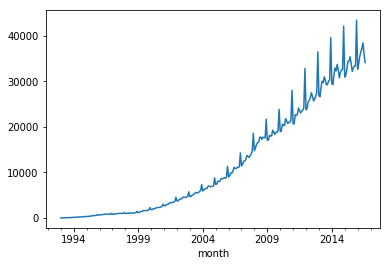

In [53]:
%pylab inline
import matplotlib.pyplot as plt
payments.WAG_C_M.plot()

 STL декомпозиция

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

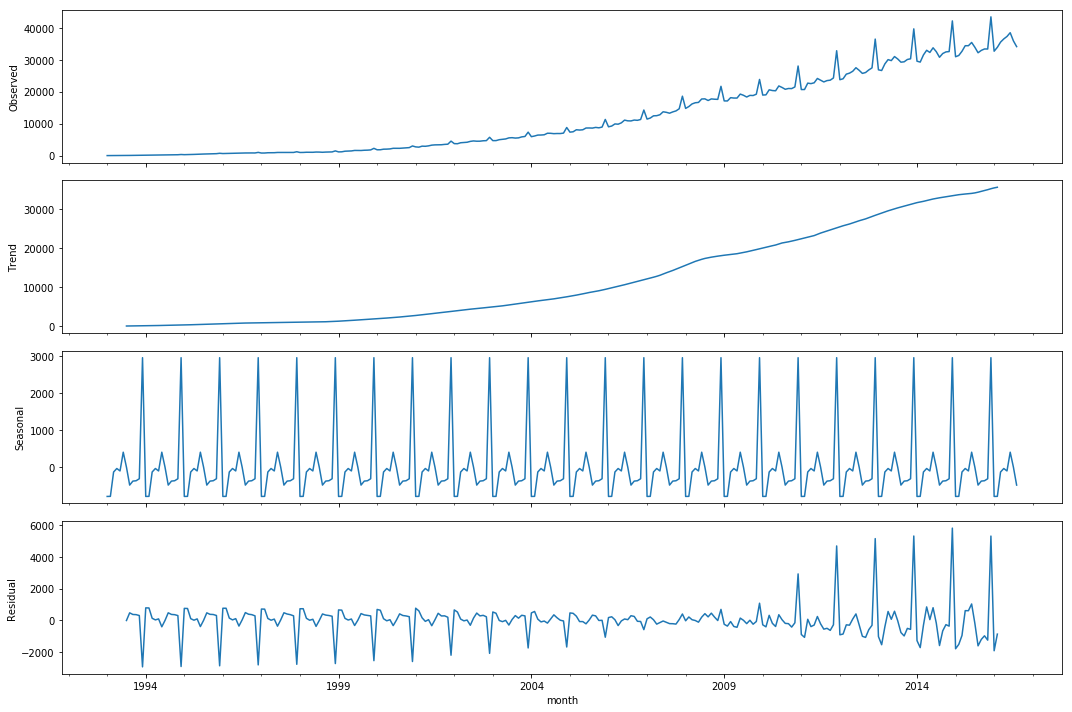

In [54]:
from scipy import stats
import statsmodels.api as sm

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(payments.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(payments.WAG_C_M)[1])

# 2. Стабилизация дисперсии (при необходимости) 

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


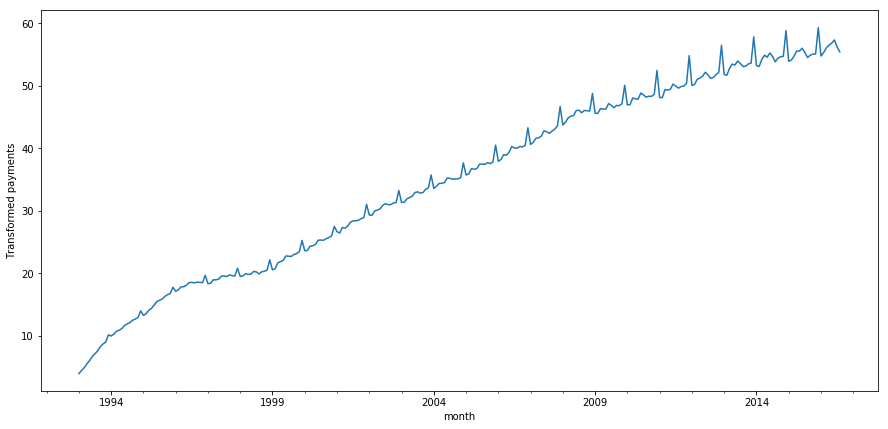

In [55]:
payments['box_transform'], lmbda = stats.boxcox(payments.WAG_C_M)
plt.figure(figsize(15,7))
payments.box_transform.plot()
plt.ylabel(u'Transformed payments')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(payments.box_transform)[1])

# 3. Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

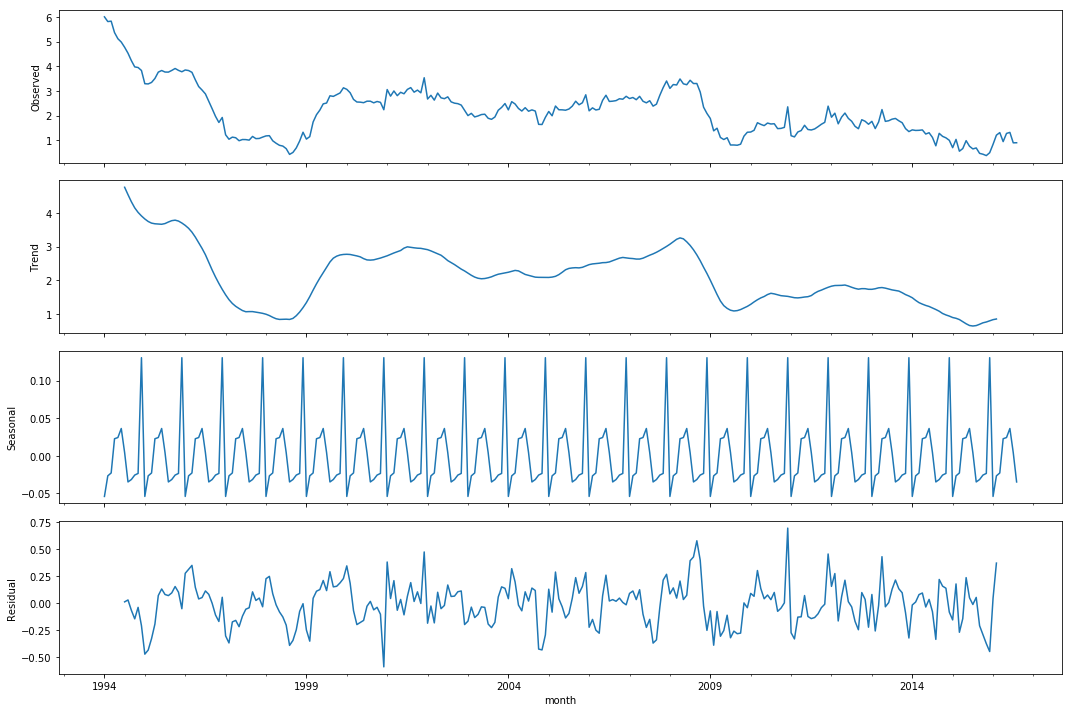

In [56]:
# Season derivation

payments['box_transform_season_diff'] = payments.box_transform - payments.box_transform.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(payments.box_transform_season_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(payments.box_transform_season_diff[12:])[1])




Глядя на коэффициент Дики-Фулера кажется, что стационарность достигнута, однако визуально виден некоторый тренд на уменьшение, поэтому добавим к сезонному дифференцированию еще и обычное 

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

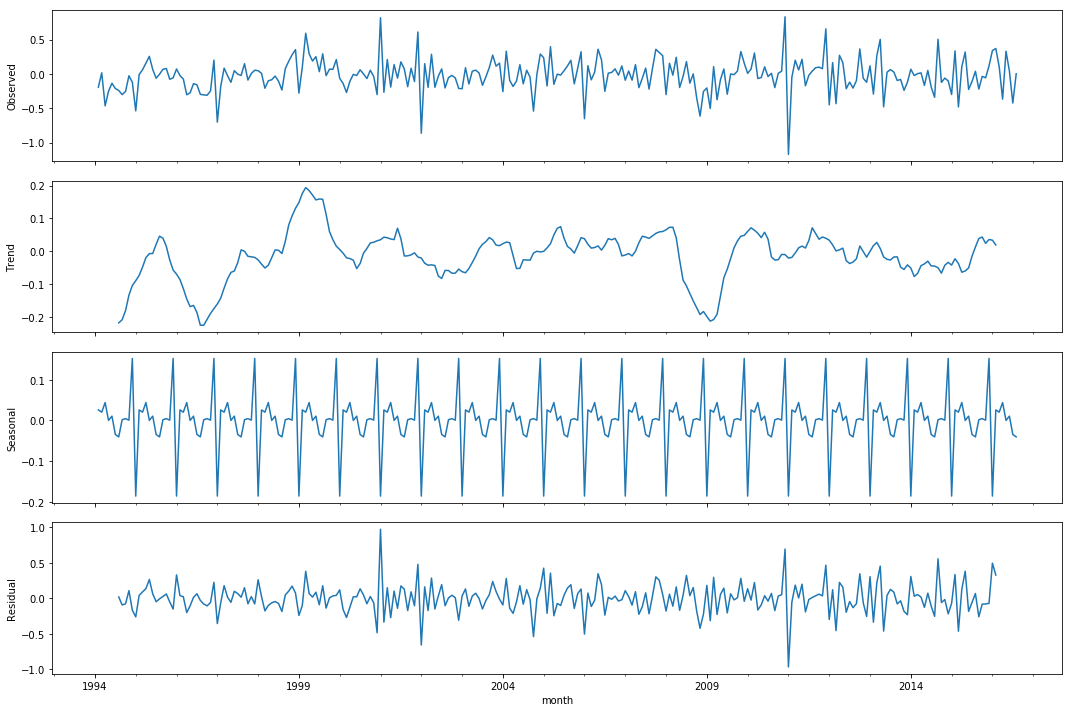

In [57]:
payments['box_transform_season_diff_diff'] = payments.box_transform_season_diff - payments.box_transform_season_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(payments.box_transform_season_diff_diff[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(payments.box_transform_season_diff_diff[13:])[1])


# 4. Выбор начальных приближений для p, q, P, Q

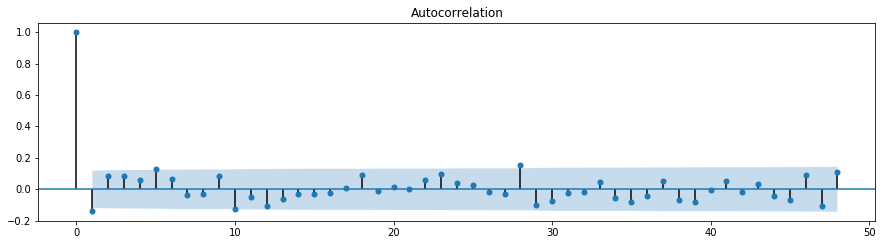

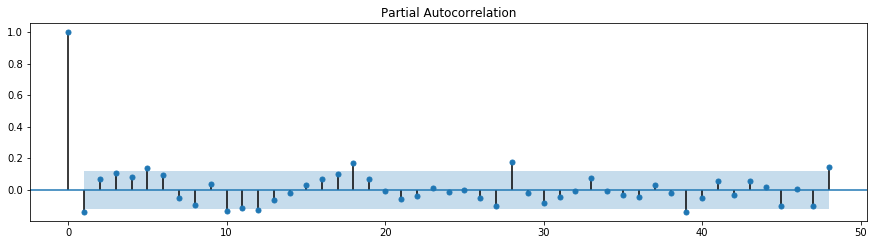

In [58]:
# ACF и PACF полученного ряда
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(payments.box_transform_season_diff_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(payments.box_transform_season_diff_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=2, q=5, P=1, p=5

In [59]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [60]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(list(parameters_list))

144

# 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [61]:
import warnings

In [62]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(payments.box_transform, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 0, 1))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4, 1, 1))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 0, 1))
('wrong parameters:', (5, 2, 1, 0))
('wrong parameters:', (5, 2,

In [63]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
106  (5, 5, 1, 0) -25.117860
105  (5, 5, 0, 1) -24.531517
107  (5, 5, 1, 1) -23.994161
93   (4, 5, 0, 1) -23.536528
94   (4, 5, 1, 0) -23.323097


Лучшая модель:

In [64]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      box_transform   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.559
Date:                            Thu, 31 Jan 2019   AIC                            -25.118
Time:                                    14:19:23   BIC                             18.108
Sample:                                01-01-1993   HQIC                            -7.762
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2328      1.571     -0.148      0.882      -3.312       2.846
ar.L2          0.2290      1.101   

# 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.167801
Критерий Дики-Фуллера: p=0.000000


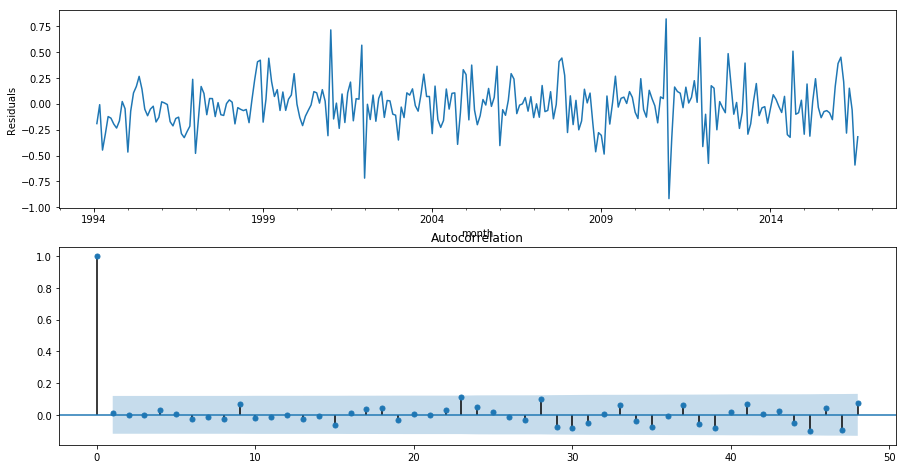

In [78]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки немного смещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).

Посчитаем среднее значение остатков (константа, на которую надо скорректировать наш ряд)

In [79]:
bias = .mean()
print bias

-0.0185072910263


In [107]:
def shift(y, bias):
    return y - bias

Критерий Стьюдента: p=1.000000


IndexError: tuple index out of range

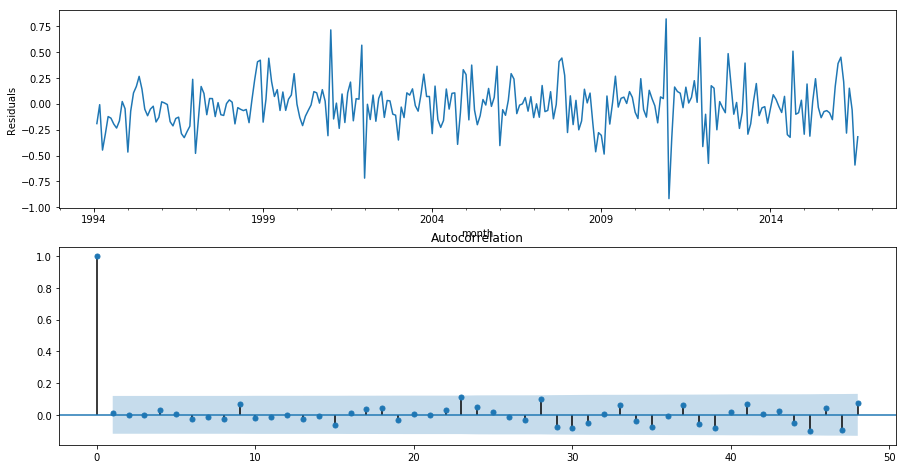

In [104]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(shift(best_model.resid[13:], bias).values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(shift(best_model.resid[13:], bias), 0)[1])




Остатки не смещены (подтверждается критерием Стьюдента)

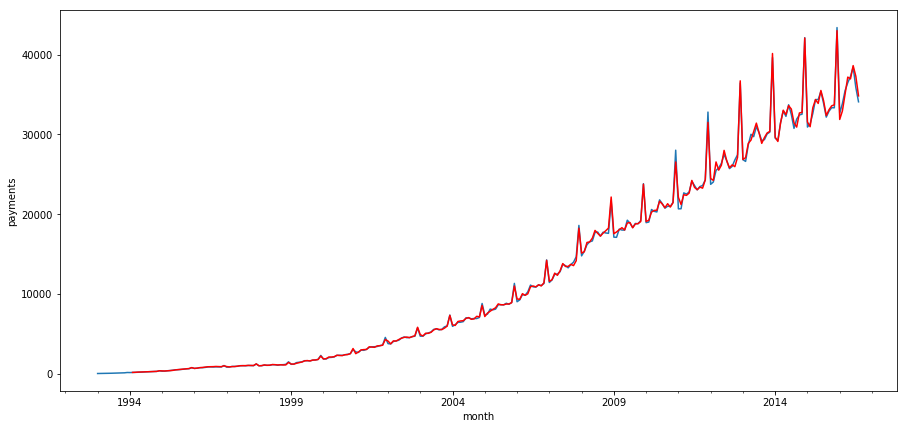

In [88]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
payments['model'] = invboxcox(shift(best_model.fittedvalues, bias), lmbda)
plt.figure(figsize(15,7))
payments.WAG_C_M.plot()
payments.model[13:].plot(color='r')
plt.ylabel('payments')
pylab.show()

# 7. Прогнозирование с помощью финальной модели.

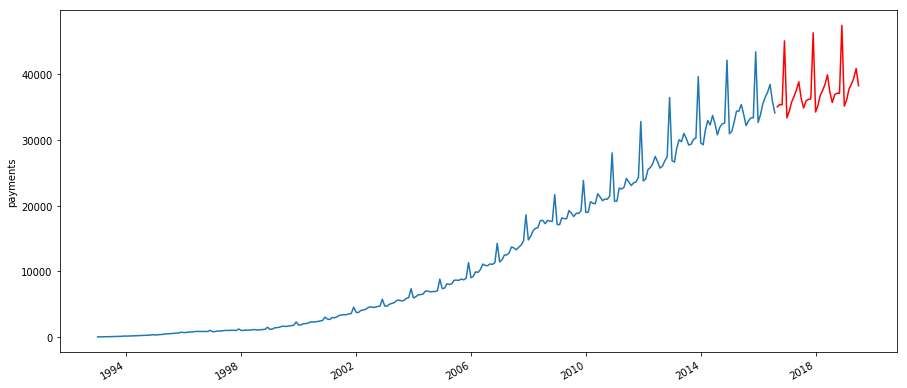

In [103]:
payments2 = payments[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= payments2.columns)
payments2 = pd.concat([payments2, future])
payments2['forecast'] = invboxcox(best_model.predict(start=284, end=350), lmbda)

plt.figure(figsize(15,7))
payments2.WAG_C_M.plot()
payments2.forecast.plot(color='r')
plt.ylabel('payments')
pylab.show()